In [20]:
pip install ripser

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [22]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/jvtraplx4to7r5y3zzq4x/collaborations_Mathematical-Physics_105.csv.gz?rlkey=zfwbarxtgk8mm39rq8wz084ma&st=uagb53zy&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1058197409,2001,ur.011354531601.87
1,pub.1058197409,2001,ur.011663011361.49
2,pub.1058194732,1981,ur.010165172102.13
3,pub.1058194732,1981,ur.012356227236.62
4,pub.1058194732,1981,ur.014467670703.92
...,...,...,...
693622,pub.1104998165,2018,ur.0732233414.25
693623,pub.1033208781,2002,ur.011170022015.06
693624,pub.1092523788,2017,ur.010122671761.59
693625,pub.1092523788,2017,ur.013642004376.72


In [23]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/4xf8k1qkqqhf0obgfntug/articles_Mathematical-Physics_105.csv.gz?rlkey=ry94p2lk666900ph12uf4xn4p&st=ujpgk5rh&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_17898/1696472445.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

In [3]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/8s7vnoz4m7y53n3mkb9at/concepts_Applied-Mathematics_102.csv-1.gz?rlkey=jkbz4d9keyrwpapzb5w1vkbbm&st=maf7pyxh&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1011927506,2001,abi raising standards scheme,0.0,1,0,1,1
1,pub.1091536887,1988,attu conventional arm control forum,0.0,1,0,1,1
2,pub.1127413625,1997,av 8 harrier,0.0,1,0,1,1
3,pub.1021705670,2010,advertisement game strategy,0.0,1,0,1,1
4,pub.1058195248,1984,aramovich aleksandryan,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...
26399751,pub.1015682740,2008,’s ψ11 summation formula,0.0,1,29,1,1
26399752,pub.1140295407,2021,’ ω transform,0.0,1,4,1,1
26399753,pub.1039011473,2010,’ ϵ variational principle,0.0,1,32,1,1
26399754,pub.1128915375,2020,′ | z | 2 d,0.0,1,16,1,1


In [4]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
46607,pub.1110525015,ad hoc networks,2018
46609,pub.1061389704,ad hoc networks,2009
46610,pub.1128617440,ad hoc networks,2020
46611,pub.1103595830,ad hoc networks,2018
46612,pub.1053051088,ad hoc networks,2013
...,...,...,...
26376853,pub.1024144862,zero sum stochastic differential game,2008
26376854,pub.1122600451,zero sum stochastic differential game,2019
26376855,pub.1072010385,zero sum stochastic differential game,2012
26376856,pub.1092410835,zero sum stochastic differential game,2017


In [5]:
# get the initial publication
concepts = (
        df
            .sort_values('year')  # sort so earliest year is first
            .groupby('concept')
            .agg(
                year=('year', 'min'),
                count=('article_id', 'nunique')
            )
            .reset_index()
    )

# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

concepts

,concept,year,count,norm_year
0,abstract differential equation,1956,32,0.356436
1,abstract evolution equations,1972,22,0.514851
2,accurate mathematical model,1961,84,0.405941
3,accurate numerical solution,1966,24,0.455446
4,acoustic emission,2011,27,0.900990
...,...,...,...,...
4596,zero coupon bond,1995,19,0.742574
4597,zero order hold,1970,38,0.495050
4598,zero sum differential game,1971,59,0.504950
4599,zero sum game,1982,35,0.613861


In [6]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
# edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
edges = edges.groupby(['concept_source', 'concept_target']).agg(
        year=('year', 'min'),
        count=('article_id', 'nunique')
    ).reset_index()

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

edges

,concept_source,concept_target,year,count,norm_year
0,abstract differential equation,approximate controllability,2000,1,0.792079
1,abstract differential equation,approximation of solution,1973,1,0.524752
2,abstract differential equation,banach space,2016,1,0.950495
3,abstract differential equation,boundary control problem,1988,1,0.673267
4,abstract differential equation,boundary control system,2013,2,0.920792
...,...,...,...,...,...
141164,yang mills,yang mills theory,1987,4,0.663366
141165,yang mills equation,yang mills theory,1984,4,0.633663
141166,zero sum differential game,zero sum game,2018,2,0.970297
141167,zero sum differential game,zero sum stochastic differential game,1995,2,0.742574


# Co-occurance statisitc

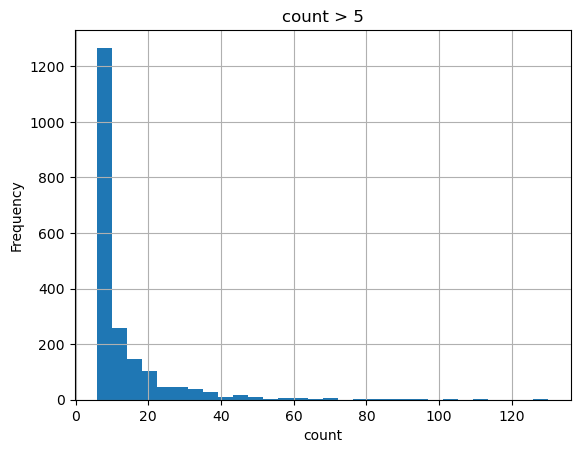

In [7]:
subset = edges[edges['count'] > 5]
subset['count'].hist(bins=30)
plt.xlabel('count')
plt.ylabel('Frequency')
plt.title('count > 5')
plt.show()

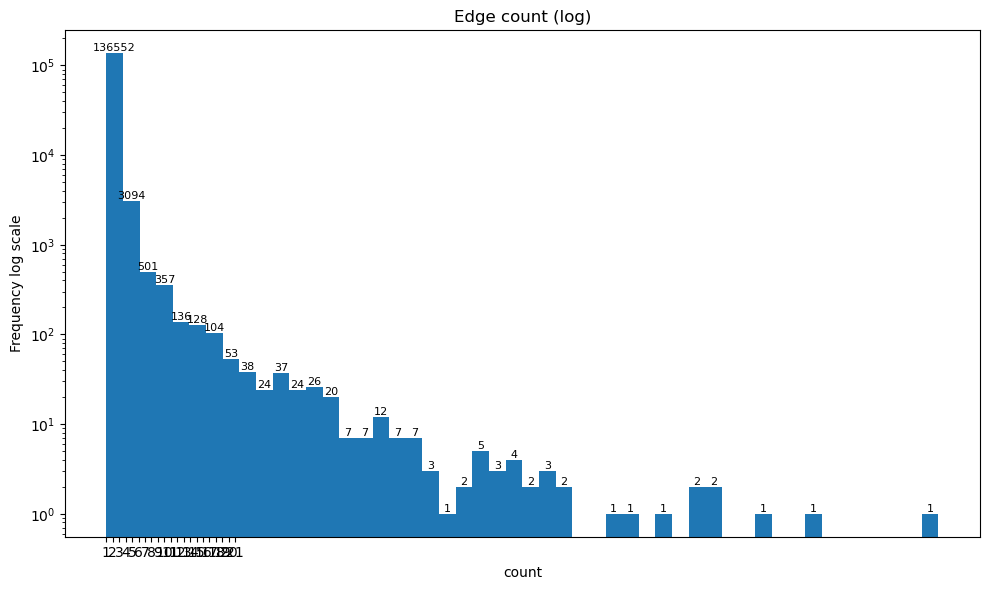

In [8]:
counts, bins = np.histogram(edges['count'], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1] - bins[0]))
plt.yscale('log')
plt.xlabel('count')
plt.ylabel('Frequency log scale')
plt.title('Edge count (log)')
for x, y in zip(bin_centers, counts):
    if y > 0:
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xticks(np.arange(1, 22, 1))
plt.tight_layout()
plt.show()

In [9]:
import oat_python as oat

In [10]:
def createsubgraph(edges, n):
    edges_single = edges[edges['count'] >= n]
    concepts_used = set(edges_single['concept_source']) | set(edges_single['concept_target'])
    concepts_sub = concepts[concepts['concept'].isin(concepts_used)]

    G_sub = nx.Graph()

    G_sub.add_nodes_from([
        (c, {'norm_year': ny, 'count': ic}) 
        for c, ny, ic in zip(concepts_sub['concept'], concepts_sub['norm_year'], concepts_sub['count'])
    ])

    G_sub.add_edges_from([
        (u, v, {'norm_year': ny, 'count': ic}) 
        for u, v, ny, ic in zip(edges_single['concept_source'], edges_single['concept_target'],
                                edges_single['norm_year'], edges_single['count'])
    ])
    return G_sub

G_sub1 = createsubgraph(edges,1)
G_sub2 = createsubgraph(edges,2)
G_sub3 = createsubgraph(edges,3)
G_sub4 = createsubgraph(edges,4)

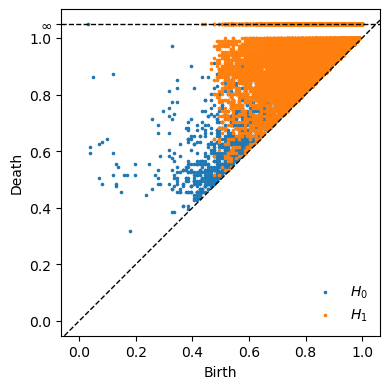

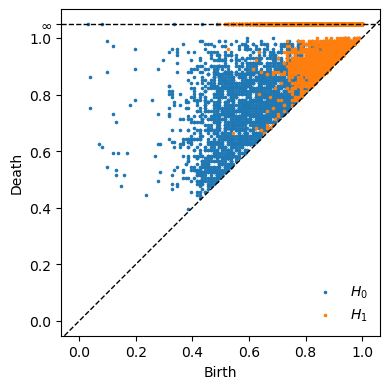

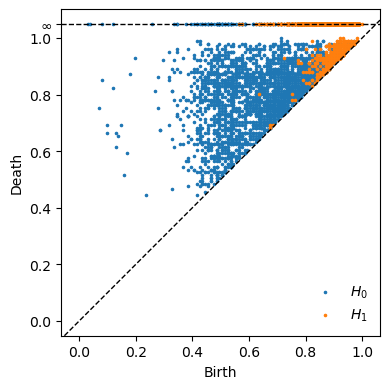

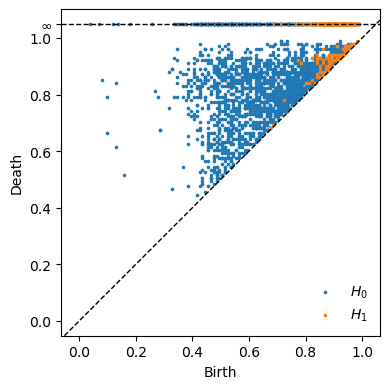

In [11]:
def gethomology(G_sub):
    node_list = list(G_sub.nodes) 
    node_index = {i: node_list[i] for i in range(len(node_list))}   
    reverse_index = {v: k for k, v in node_index.items()}           

    adj = nx.adjacency_matrix(G_sub, nodelist=node_list, weight='norm_year')
    adj.setdiag([G_sub.nodes[n]['norm_year'] for n in node_list])
    adj = adj.sorted_indices()

    factored = oat.rust.FactoredBoundaryMatrixVr(adj, 1)
    homology = factored.homology(
        return_cycle_representatives=True,
        return_bounding_chains=True
    )

    return homology, node_index 

def draw_persistent_diag(G_sub):
    homology,node = gethomology(G_sub)
    # initialize the plot
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(4)
    infty = 1.05
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.axis('equal')

    # lines
    ax.axhline(infty, ls='--', c='k', lw=1)
    ax.axline([0, 0], [1, 1], ls='--', c='k', lw=1)

    # loop, plot homology
    for dim in homology['dimension'].unique():
        dim_bc = homology[homology['dimension'] == dim]
        ax.scatter(dim_bc['birth'], dim_bc['death'].replace(np.inf, infty), s=2.5, label=f'$H_{dim}$')

    # final formatting
    ticks = ax.get_yticklabels()[1:-1]
    ticks.append(Text(0, infty, r'$\infty$'))  # add infty label
    ax.set_yticks(np.hstack((ax.get_yticks()[1:-1], infty)))
    ax.set_yticklabels(ticks)
    ax.legend(frameon=False)
    fig.tight_layout()

draw_persistent_diag(G_sub1)
draw_persistent_diag(G_sub2)
draw_persistent_diag(G_sub3)
draw_persistent_diag(G_sub4)

In [12]:
import ast
import re

In [13]:
df_homology1 = gethomology(G_sub1)
df_homology2 = gethomology(G_sub2)
df_homology3 = gethomology(G_sub3)
df_homology4 = gethomology(G_sub4)

def picklargestcycle(df_homology, node_index, max_filtration_val=1.05):
    df_H1 = df_homology[df_homology['dimension'] == 1].copy()
    df_H1['death_mod'] = df_H1['death'].replace(np.inf, max_filtration_val)
    df_H1['persistence'] = df_H1['death_mod'] - df_H1['birth']

    df_H1_sorted = df_H1.sort_values(by=['persistence', 'birth'], ascending=[False, True])
    target_bar = df_H1_sorted.iloc[0]
    print(f"Selected bar: birth={target_bar['birth']}, death={target_bar['death']}, persistence={target_bar['persistence']}")

    pattern_all = r"\[([0-9,\s]+)\]"
    matches = re.findall(pattern_all, str(target_bar['cycle representative']))

    edge_list = []
    for m in matches:
        local_nodes = list(map(int, m.strip().split(',')))
        real_nodes = [node_index[i] for i in local_nodes]  # 恢复原始 concept ID
        if len(real_nodes) == 2:
            edge_list.append(tuple(real_nodes))
        elif len(real_nodes) > 2:
            edge_list.extend([(real_nodes[i], real_nodes[(i+1)%len(real_nodes)]) for i in range(len(real_nodes))])

    node_set = set([n for edge in edge_list for n in edge])
    print("Nodes involved in generator:", node_set)
    print("Edges:", edge_list)

    return node_set, edge_list

Selected bar: birth=0.43564356435643564, death=inf, persistence=0.6143564356435645
Nodes involved in generator: {'random input', 'asymptotic method', 'automatic control system', 'second order system', 'sample datum control system'}
Edges: [('asymptotic method', 'second order system'), ('asymptotic method', 'automatic control system'), ('automatic control system', 'random input'), ('random input', 'sample datum control system'), ('sample datum control system', 'second order system')]


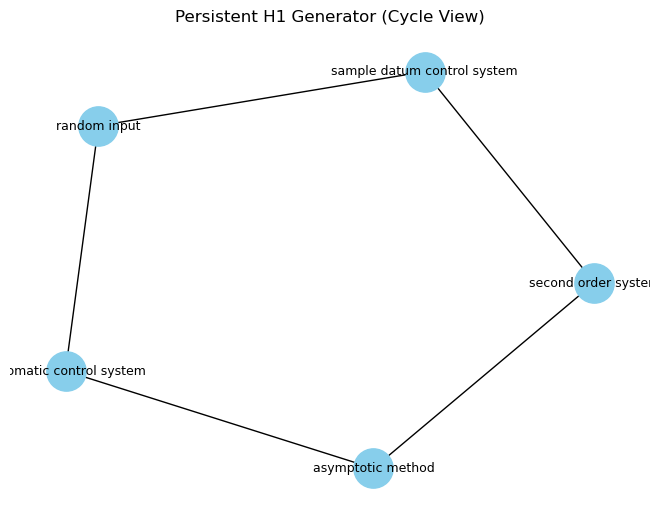

Selected bar: birth=0.5643564356435643, death=inf, persistence=0.48564356435643574
Nodes involved in generator: {'feedback gain matrix', 'infinite time interval', 'finite time interval', 'quadratic performance criterion', 'open loop control', 'output feedback gain'}
Edges: [('finite time interval', 'open loop control'), ('feedback gain matrix', 'open loop control'), ('feedback gain matrix', 'output feedback gain'), ('infinite time interval', 'quadratic performance criterion'), ('finite time interval', 'infinite time interval'), ('output feedback gain', 'quadratic performance criterion')]


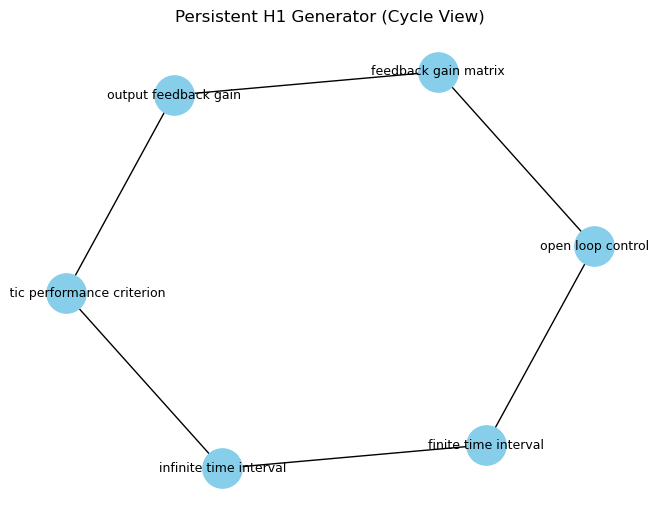

Selected bar: birth=0.6831683168316832, death=inf, persistence=0.3668316831683168
Nodes involved in generator: {'order partial differential equation', 'second order equation', 'viscosity solution', 'first order equation', 'first order partial differential equation'}
Edges: [('second order equation', 'viscosity solution'), ('first order equation', 'second order equation'), ('first order partial differential equation', 'viscosity solution'), ('first order equation', 'order partial differential equation'), ('first order partial differential equation', 'order partial differential equation')]


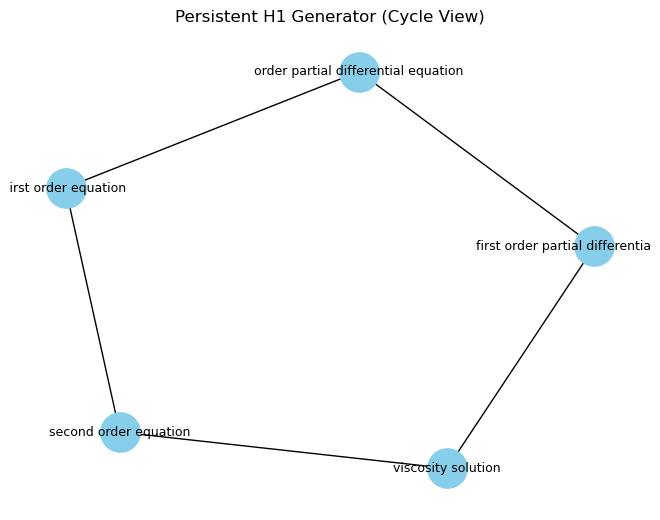

In [14]:
def drawlargecycle(df_homology, node_index, G_sub, max_filtration_val=1.05, show_labels=True):
    node_set, edge_list = picklargestcycle(df_homology, node_index, max_filtration_val)
    H = nx.Graph()
    H.add_nodes_from(node_set)
    H.add_edges_from(edge_list)
    pos = nx.spring_layout(H, seed=42)

    if show_labels:
        labels = {
            n: G_sub.nodes[n]['label'] if 'label' in G_sub.nodes[n] else str(n)
            for n in H.nodes
        }
    else:
        labels = None
    nx.draw(H, pos, with_labels=show_labels, labels=labels,
            node_color='skyblue', node_size=800, font_size=9)
    
    plt.title("Persistent H1 Generator (Cycle View)")
    plt.axis('off')
    plt.show()

df_homology1, node_index1 = gethomology(G_sub1)
df_homology2, node_index2 = gethomology(G_sub2)
df_homology3, node_index3 = gethomology(G_sub3)
df_homology4, node_index4 = gethomology(G_sub4)
drawlargecycle(df_homology1, node_index1, G_sub1)
#drawlargecycle(df_homology2, node_index2, G_sub2)
drawlargecycle(df_homology3, node_index3, G_sub3)
drawlargecycle(df_homology4, node_index4, G_sub4)